### GIS data preparation

the solution found at https://gis.stackexchange.com/questions/157693/getting-all-vertex-lat-long-coordinates-every-1-meter-between-two-known-points
refering to http://www.movable-type.co.uk/scripts/latlong.html which has formulas in Java Script and for Excel

Python function adaptations


#### Importing all needed modules and libraries

In [1]:
import pandas as pd
import math

#### GIS functions needed for coordinates calculation

In [10]:
def getPathLength(lat1,lng1,lat2,lng2):
    '''calculates the distance between two lat, long coordinate pairs'''
    R = 6371000 # radius of earth in m
    lat1rads = math.radians(lat1)
    lat2rads = math.radians(lat2)
    deltaLat = math.radians((lat2-lat1))
    deltaLng = math.radians((lng2-lng1))
    a = math.sin(deltaLat/2) * math.sin(deltaLat/2) + math.cos(lat1rads) * math.cos(lat2rads) * math.sin(deltaLng/2) * math.sin(deltaLng/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    return d

def calculateBearing(lat1,lng1,lat2,lng2):
    '''calculates the azimuth in degrees from start point to end point'''
    startLat = math.radians(lat1)
    startLong = math.radians(lng1)
    endLat = math.radians(lat2)
    endLong = math.radians(lng2)
    dLong = endLong - startLong
    dPhi = math.log(math.tan(endLat/2.0+math.pi/4.0)/math.tan(startLat/2.0+math.pi/4.0))
    if abs(dLong) > math.pi:
         if dLong > 0.0:
             dLong = -(2.0 * math.pi - dLong)
         else:
             dLong = (2.0 * math.pi + dLong)
    bearing = (math.degrees(math.atan2(dLong, dPhi)) + 360.0) % 360.0;
    return bearing

def getDestinationLatLong(lat,lng,azimuth,distance):
    '''returns the lat and long of destination point 
    given the start lat, long, aziuth, and distance'''
    R = 6378.1 #Radius of the Earth in km
    brng = math.radians(azimuth) #Bearing is degrees converted to radians.
    d = distance/1000 #Distance m converted to km
    lat1 = math.radians(lat) #Current dd lat point converted to radians
    lon1 = math.radians(lng) #Current dd long point converted to radians
    lat2 = math.asin(math.sin(lat1) * math.cos(d/R) + math.cos(lat1)* math.sin(d/R)* math.cos(brng))
    lon2 = lon1 + math.atan2(math.sin(brng) * math.sin(d/R)* math.cos(lat1), math.cos(d/R)- math.sin(lat1)* math.sin(lat2))
    #convert back to degrees
    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)
    return[lat2, lon2]

def coord(interval,azimuth,lat1,lng1,lat2,lng2):
    '''returns every coordinate pair between two coordinate 
    pairs given the desired interval'''

    d = getPathLength(lat1,lng1,lat2,lng2)
    remainder, dist = math.modf((d / interval))
    counter = float(interval)
    coords = []
    coords.append([lat1,lng1])
    for distance in range(1,int(dist)):       # have to modify from original as it did not take into account the beginning/end point coordinates
        coord = getDestinationLatLong(lat1,lng1,azimuth,counter)
        counter = counter + float(interval)
        coords.append(coord)
    coords.append([lat2,lng2])
    return coords


In [77]:
# calculate K - Wenner
mn = 0.30
Kgeom = 2 * math.pi * mn
Kgeom

1.8849555921538759

In [98]:
# add REScorrect
df_erGIS['REScorrect'] = df_erGIS['RESapparent'] * Kgeom / 2.13

#### Load GIS and Apparent Resistivity data for HEP from CSV file

In [186]:
# load CSV in dictionary and df
# RESa data df
filename = 'hep_5'
df_res = pd.read_csv(filename + '.csv', skiprows=6) # see the file on how many rows to skip, standard 6
#df_res = pd.read_csv('hep_5.csv', skiprows=6)

# CSV from Excel sometimes import completely empty extra rows and columns, this will get rid of them
df_res.dropna(axis=1, how='all', inplace=True)
#df_res.dropna(axis=0, how='all', inplace=True)

df_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   41.06153846  106 non-null    float64
dtypes: float64(1)
memory usage: 1.0 KB


In [187]:
print('count ' + df_res.count().astype(str))
df_res.shape[0]
#print('number of rows ' + len(df_res.index).astype(str))

41.06153846    count 106
dtype: object


114

In [185]:
# load start and finish points of HEP profile to a separate df
df_gis = pd.read_csv(filename +'.csv', nrows=5, header=None)
df_gis

,0,1,2
0,"Начало (широта, долгота)",56.039415,37.167798
1,"Конец (широта, долгота)",56.040911,37.168846
2,шаг (м),1.500000,NaN
3,АВ (м),1.500000,NaN
4,К-геом (м),3.140000,NaN


In [188]:
# prepare GIS data to calculate profile locations
lat1 = df_gis.iloc[0, 1]
lng1 = df_gis.iloc[0, 2]

lat2 = df_gis.iloc[1, 1]
lng2 = df_gis.iloc[1, 2]


In [189]:
# calculating length of the whole profile
HEP_dist = getPathLength(lat1,lng1,lat2,lng2)
HEP_dist

178.631056183308

In [190]:
# calculate actual step of measurements - HEP_dist / count of df_res
HEP_step = HEP_dist / (df_res.shape[0] - 1)
HEP_step

1.5808058069319293

In [191]:
# calculate direction (azimuth or bearing of the profile)
HEP_dir = calculateBearing(lat1,lng1,lat2,lng2)
HEP_dir

21.371741030871533

In [192]:
# calculating lat-long for all RESa measurements
coord_list = coord(HEP_step,HEP_dir,lat1,lng1,lat2,lng2)
coord_list

[[56.039415, 37.167798],
 [56.03942822420032, 37.16780726383583],
 [56.039441448399955, 37.16781652767803],
 [56.039454672598914, 37.16782579152657],
 [56.039467896797156, 37.16783505538146],
 [56.039481120994715, 37.1678443192427],
 [56.03949434519157, 37.16785358311028],
 [56.03950756938773, 37.167862846984214],
 [56.03952079358319, 37.1678721108645],
 [56.03953401777798, 37.16788137475114],
 [56.03954724197206, 37.167890638644124],
 [56.039560466165454, 37.16789990254345],
 [56.03957369035814, 37.16790916644914],
 [56.039586914550156, 37.167918430361176],
 [56.039600138741456, 37.167927694279555],
 [56.03961336293207, 37.16793695820429],
 [56.039626587121994, 37.16794622213537],
 [56.039639811311226, 37.1679554860728],
 [56.039653035499754, 37.16796475001658],
 [56.0396662596876, 37.167974013966706],
 [56.03967948387472, 37.167983277923184],
 [56.03969270806118, 37.167992541886015],
 [56.03970593224693, 37.168001805855184],
 [56.03971915643199, 37.16801106983071],
 [56.0397323806163

In [193]:
# converting coordinate list to df and merging with RESa data 
df_ptgis = pd.DataFrame(coord_list)
df_ptgis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       114 non-null    float64
 1   1       114 non-null    float64
dtypes: float64(2)
memory usage: 1.9 KB


In [194]:
# merge two df and add headers
df_erGIS = df_ptgis.join(df_res)
df_erGIS.columns = ['Latitude', 'Longitude', 'RESapparent']
df_erGIS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Latitude     114 non-null    float64
 1   Longitude    114 non-null    float64
 2   RESapparent  106 non-null    float64
dtypes: float64(3)
memory usage: 2.8 KB


In [195]:
# add column with file name
df_erGIS['data_set'] = filename

In [196]:
# calculating summary statistics
df_erGIS['RESapparent'].describe().round(1)

count    106.0
mean      82.2
std       50.6
min       23.6
25%       58.8
50%       74.9
75%       90.9
max      498.1
Name: RESapparent, dtype: float64

In [197]:
df_erGIS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Latitude     114 non-null    float64
 1   Longitude    114 non-null    float64
 2   RESapparent  106 non-null    float64
 3   data_set     114 non-null    object 
dtypes: float64(3), object(1)
memory usage: 3.7+ KB


In [198]:
# saving results as CSV - individual file

df_erGIS.to_csv('gis_' + filename + '.csv', index=False)


In [178]:
all_erGIS.drop(all_erGIS[all_erGIS['data_set'] == 'hep_4a'].index, inplace=True)

In [179]:
all_erGIS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 78 to 85
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Latitude     14 non-null     float64
 1   Longitude    14 non-null     float64
 2   RESapparent  14 non-null     float64
 3   data_set     14 non-null     object 
 4   Comments     8 non-null      object 
dtypes: float64(3), object(2)
memory usage: 672.0+ bytes


In [199]:
all_erGIS = pd.read_csv('gis23_hep_all.csv')
all_erGIS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Latitude     292 non-null    float64
 1   Longitude    292 non-null    float64
 2   RESapparent  292 non-null    float64
 3   data_set     292 non-null    object 
 4   Comments     158 non-null    object 
dtypes: float64(3), object(2)
memory usage: 11.5+ KB


In [205]:
# appending all processed data sets to one df and CSV - with labels of individual files

#all_erGIS = pd.DataFrame() #- initiate empty DF at the start, then comment out
all_erGIS = pd.concat([all_erGIS, df_4a], axis=0)


In [206]:
all_erGIS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484 entries, 0 to 77
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Latitude     484 non-null    float64
 1   Longitude    484 non-null    float64
 2   RESapparent  476 non-null    float64
 3   data_set     484 non-null    object 
 4   Comments     158 non-null    object 
dtypes: float64(3), object(2)
memory usage: 22.7+ KB


In [203]:
#append 4a CSV

df_4a = pd.read_csv('gis_hep_4a.csv')

In [204]:
df_4a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Latitude     78 non-null     float64
 1   Longitude    78 non-null     float64
 2   RESapparent  78 non-null     float64
 3   data_set     78 non-null     object 
dtypes: float64(3), object(1)
memory usage: 2.6+ KB


In [208]:
all_erGIS.describe().round(1)

,Latitude,Longitude,RESapparent
count,484.0,484.0,476.0
mean,56.0,37.2,515.5
std,0.0,0.0,612.5
min,56.0,37.2,23.6
25%,56.0,37.2,91.6
50%,56.0,37.2,176.8
75%,56.0,37.2,962.7
max,56.0,37.2,3304.0


array([[<AxesSubplot: title={'center': 'hep_1'}>,
        <AxesSubplot: title={'center': 'hep_2'}>],
       [<AxesSubplot: title={'center': 'hep_3-1'}>,
        <AxesSubplot: title={'center': 'hep_3-2'}>],
       [<AxesSubplot: title={'center': 'hep_4a'}>,
        <AxesSubplot: title={'center': 'hep_5'}>]], dtype=object)

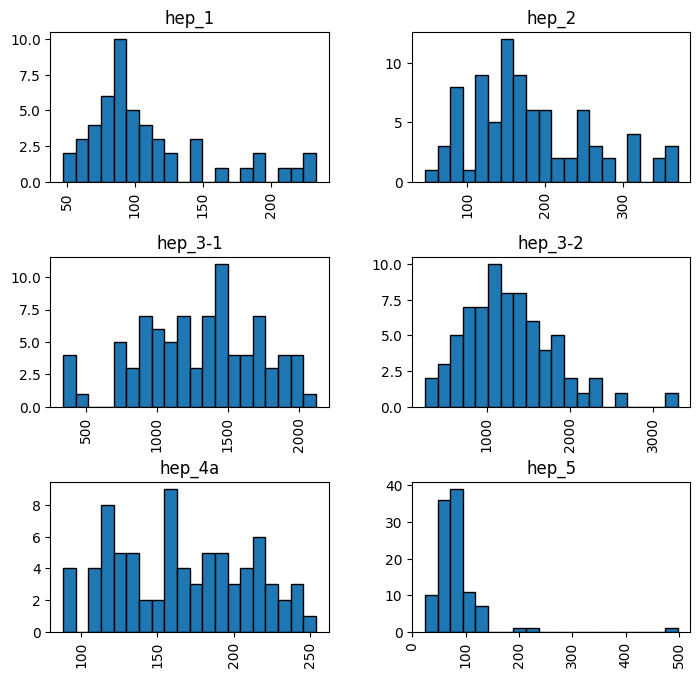

In [219]:
all_erGIS['RESapparent'].hist(bins=20, by=all_erGIS['data_set'], edgecolor='black', figsize=(8,8))

In [220]:
df = all_erGIS.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484 entries, 0 to 77
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Latitude     484 non-null    float64
 1   Longitude    484 non-null    float64
 2   RESapparent  476 non-null    float64
 3   data_set     484 non-null    object 
 4   Comments     158 non-null    object 
dtypes: float64(3), object(2)
memory usage: 22.7+ KB


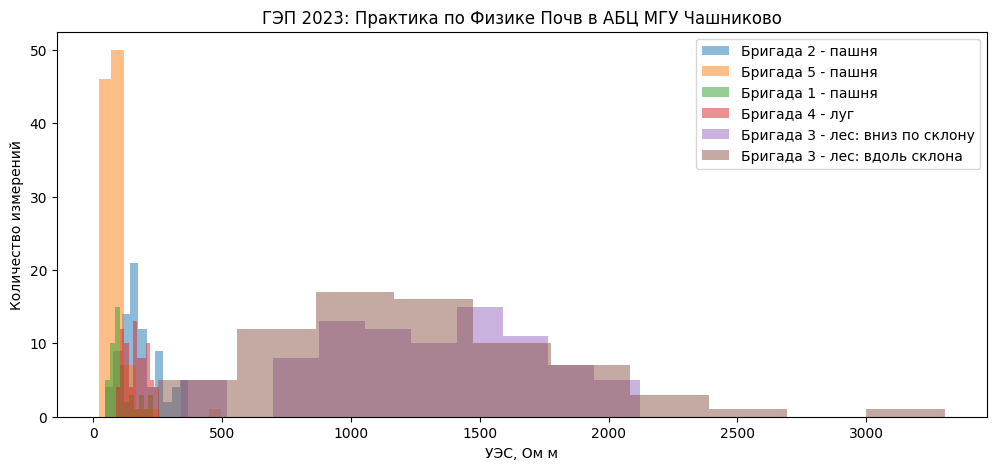

File with graph created, you can run other location now!


<Figure size 1200x500 with 0 Axes>

In [230]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 5))   # this is to overwrite default aspect of graph 
                                          #to make x-axis longer for modern slides

#define points values by group
A = df.loc[df['data_set'] == 'hep_1', 'RESapparent']
B = df.loc[df['data_set'] == 'hep_2', 'RESapparent']
C = df.loc[df['data_set'] == 'hep_5', 'RESapparent']
D = df.loc[df['data_set'] == 'hep_4a', 'RESapparent']
E = df.loc[df['data_set'] == 'hep_3-1', 'RESapparent']
F = df.loc[df['data_set'] == 'hep_3-2', 'RESapparent']

#add three histograms to one plot
plt.hist(B, alpha=0.5, label='Бригада 2 - пашня')
plt.hist(C, alpha=0.5, label='Бригада 5 - пашня')
plt.hist(A, alpha=0.5, label='Бригада 1 - пашня')
plt.hist(D, alpha=0.5, label='Бригада 4 - луг')
plt.hist(E, alpha=0.5, label='Бригада 3 - лес: вниз по склону')
plt.hist(F, alpha=0.5, label='Бригада 3 - лес: вдоль склона')

#add plot title and axis labels
plt.title('ГЭП 2023: Практика по Физике Почв в АБЦ МГУ Чашниково')
plt.xlabel('УЭС, Ом м')
plt.ylabel('Количество измерений')

#add legend
plt.legend(title='')

plt.savefig('2023-HEP-Chashnikovo.png',dpi=300,transparent=False)

#display plot
plt.show()
print('File with graph created, you can run other location now!')

In [207]:
# all CSV to file
all_erGIS.to_csv('gis23_hep_all.csv', index=False)
